In [1]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
from botorch.utils.sampling import draw_sobol_samples
from torch.quasirandom import SobolEngine

/opt/homebrew/Caskroom/miniconda/base/envs/botorch_mar2024/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# predict_fischer_model
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import warnings
import torch
warnings.filterwarnings("ignore")
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import BatchNormalization

from keras import backend as K
K.set_floatx('float32')
import json


# ANN structure
N_neurons=20
N_layers=1

model = Sequential()
if N_layers==1:
     model.add(Dense(N_neurons, activation = 'sigmoid', input_dim = 4))
elif N_layers==2 :
    model.add(Dense(N_neurons, activation = 'sigmoid', input_dim = 4))
    model.add(Dense(units = N_neurons, activation = 'relu'))
elif N_layers==3 :
    model.add(Dense(N_neurons, activation = 'sigmoid', input_dim = 4))
    model.add(Dense(units = N_neurons, activation = 'relu'))
    model.add(Dense(units = N_neurons, activation = 'relu'))
else:
    print("Check no of layers")
model.add(Dense(units = 4))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae'])


# Load the model
with open('fischer_ann_weights.json', 'r') as f:
    weights_list = json.load(f)

weights = [np.array(w) for w in weights_list]
model.set_weights(weights)

# Test the model
df = pd.read_csv("fischer_data_processed.csv",sep=",")
X = df.iloc[:,0:4].astype('float32')
y = df.iloc[:,4:8].astype('float32')


def predict_fischer_model(X, negate=False):
    y_pred = model.predict(X)
    y_pred=torch.Tensor(y_pred)
    return y_pred
    # if negate:
    #     return -y_pred
    # else:
    #     return y_pred

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.float32
bounds = torch.tensor([[0., 0., 0., 0.], [1., 1., 1., 1.]], dtype=dtype, device=device)

N = 7
batch_size=5
iteration_number=20

iterations = list(range(1, iteration_number+1))
supra_best=[]

cpu


In [28]:
j=3 #select between y1-y4 for the objective we want to opimize, 0 for y1, 1 for y2, 2 for y3, 3 for y4
for i in range(10):    
    #sobol sampling
    sobol_engine = SobolEngine(dimension=4, scramble=False)  # 4 dimensions for your input space
    train_x = draw_sobol_samples(bounds=bounds, n=1, q=N).squeeze(0).cpu()
    x_2=tf.convert_to_tensor(train_x, dtype=tf.float32)
    train_y = predict_fischer_model(x_2, negate=True)[:, j].unsqueeze(-1) 

    models = []

    gp_model = SingleTaskGP(train_x, train_y).to(device=device, dtype=dtype)
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_model(mll)

    models.append(gp_model)

    #acquisition function
    frames_x = [train_x.cpu().numpy()]
    frames_y = [train_y.cpu().numpy()]
    best_points = []
    best_y_values=[]

    for iteration in range(iteration_number):
        EI = qExpectedImprovement(model=gp_model, best_f=train_y.max())#, maximize=True)
        #optimisation of acquisition function
        candidate, _ = optimize_acqf(
            acq_function=EI,
            bounds=bounds,
            q=batch_size,
            num_restarts=5,
            raw_samples=20,
            options={"dtype": dtype, "device": device}
        )
        candidate_2=tf.convert_to_tensor(candidate.cpu().numpy(), dtype=tf.float32)
        new_y = predict_fischer_model(candidate_2, negate=True)[:, j].unsqueeze(-1)
        train_x = torch.cat([train_x, candidate])
        train_y = torch.cat([train_y, new_y])

        gp_model = SingleTaskGP(train_x, train_y).to(device=device, dtype=dtype)
        mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
        fit_gpytorch_model(mll)

        frames_x.append(train_x.cpu().numpy())
        frames_y.append(train_y.cpu().numpy())
        best_points.append(train_x[train_y.argmax(), :].cpu().numpy())
        best_y_values.append(train_y.max().cpu().numpy())
        models.append(gp_model)

    best_point = train_x[train_y.argmax(), :]
    best_value = train_y.max().item()

    best_y_values = np.array([element for element in best_y_values])
    supra_best.append(best_y_values)

    print("Best observed point:", best_point.cpu().numpy(), "Best observed value:", best_value)
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Best observed point: [0.        0.        0.8964167 0.       ] Best observed value: 1.0225528478622437
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/s

In [19]:
predict_fischer_model(torch.tensor([[1,0.75,0.90,1]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


tensor([[1.0221, 0.4842, 0.7739, 0.6392]])

In [58]:
np.sum(supra_best,axis=0)

array([ 9.894061,  9.985101, 10.019682, 10.085402, 10.132252, 10.14402 ,
       10.14402 , 10.149094, 10.16364 , 10.172681, 10.172681, 10.172681,
       10.172681, 10.184688, 10.185738, 10.185738, 10.192723, 10.194483,
       10.194483, 10.194483], dtype=float32)

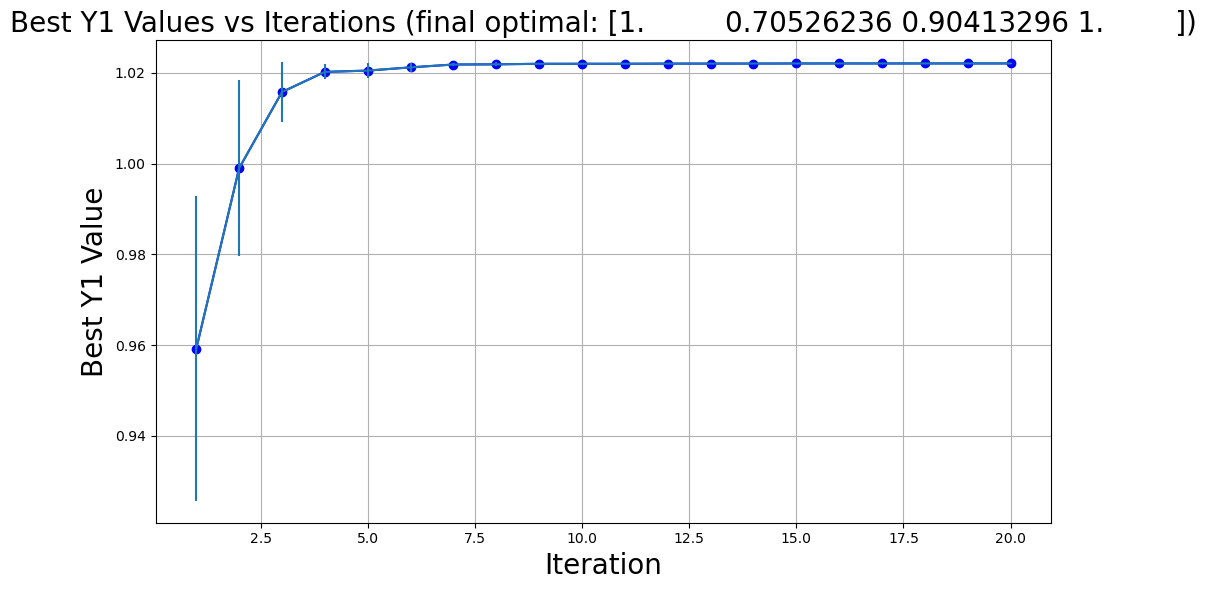

In [23]:
def plot_gp_mean(model, bounds, resolution=100):
    x1 = torch.linspace(bounds[0, 0], bounds[1, 0], resolution, dtype=dtype, device=device)
    x2 = torch.linspace(bounds[0, 1], bounds[1, 1], resolution, dtype=dtype, device=device)
    X1, X2 = torch.meshgrid(x1, x2)
    grid = torch.stack([X1.flatten(), X2.flatten()], -1)
    with torch.no_grad():
        mean = model.posterior(grid).mean.cpu().numpy().reshape(resolution, resolution)
    return X1.cpu().numpy(), X2.cpu().numpy(), mean

def update(frame):
    plt.clf()
    X1, X2, mean = plot_gp_mean(models[frame], bounds)
    cp = plt.contourf(X1, X2, mean, levels=50, cmap=cm.viridis)
    plt.colorbar(cp)
    plt.scatter(frames_x[frame][:, 0], frames_x[frame][:, 1], color="red")
    plt.title(f"Iteration {frame+1}")



# Plotting the best Y values vs iterations
plt.figure(figsize=(10, 6))
plt.plot(iterations, np.mean(supra_best,axis=0), marker='o', linestyle='-', color='b')
plt.errorbar(iterations, np.mean(supra_best,axis=0),yerr=np.std(supra_best,axis=0))
plt.title('Best Y1 Values vs Iterations (final optimal: [1.         0.70526236 0.90413296 1.        ])', fontsize = 20)
plt.xlabel('Iteration', fontsize = 20)
plt.ylabel('Best Y1 Value', fontsize = 20)
plt.grid(True)
plt.tight_layout()
plt.show()

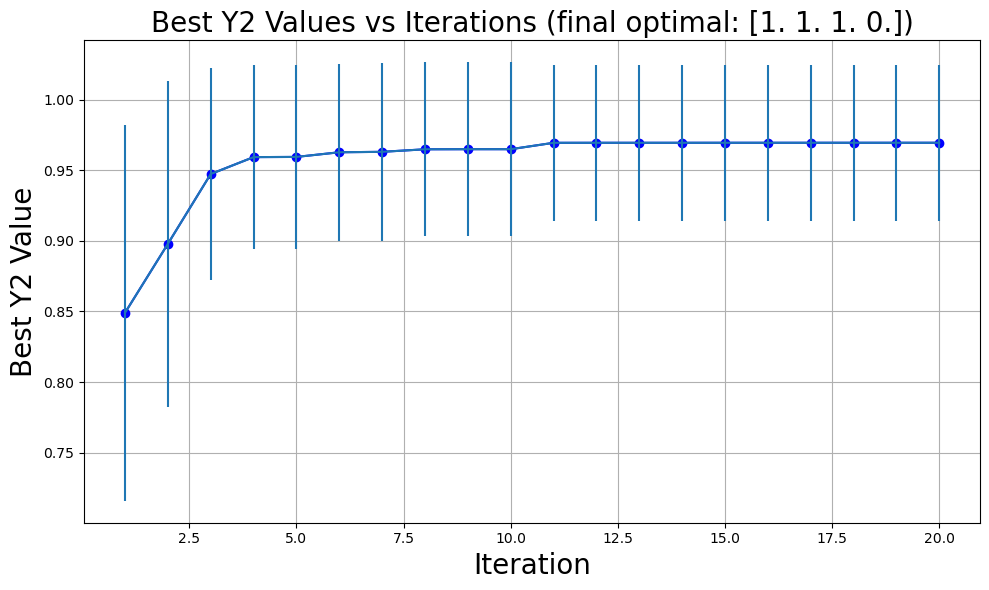

In [25]:
def plot_gp_mean(model, bounds, resolution=100):
    x1 = torch.linspace(bounds[0, 0], bounds[1, 0], resolution, dtype=dtype, device=device)
    x2 = torch.linspace(bounds[0, 1], bounds[1, 1], resolution, dtype=dtype, device=device)
    X1, X2 = torch.meshgrid(x1, x2)
    grid = torch.stack([X1.flatten(), X2.flatten()], -1)
    with torch.no_grad():
        mean = model.posterior(grid).mean.cpu().numpy().reshape(resolution, resolution)
    return X1.cpu().numpy(), X2.cpu().numpy(), mean

def update(frame):
    plt.clf()
    X1, X2, mean = plot_gp_mean(models[frame], bounds)
    cp = plt.contourf(X1, X2, mean, levels=50, cmap=cm.viridis)
    plt.colorbar(cp)
    plt.scatter(frames_x[frame][:, 0], frames_x[frame][:, 1], color="red")
    plt.title(f"Iteration {frame+1}")



# Plotting the best Y values vs iterations
plt.figure(figsize=(10, 6))
plt.plot(iterations, np.mean(supra_best,axis=0), marker='o', linestyle='-', color='b')
plt.errorbar(iterations, np.mean(supra_best,axis=0),yerr=np.std(supra_best,axis=0))
plt.title('Best Y2 Values vs Iterations (final optimal: [1. 1. 1. 0.])', fontsize = 20)
plt.xlabel('Iteration', fontsize = 20)
plt.ylabel('Best Y2 Value', fontsize = 20)
plt.grid(True)
plt.tight_layout()
plt.show()

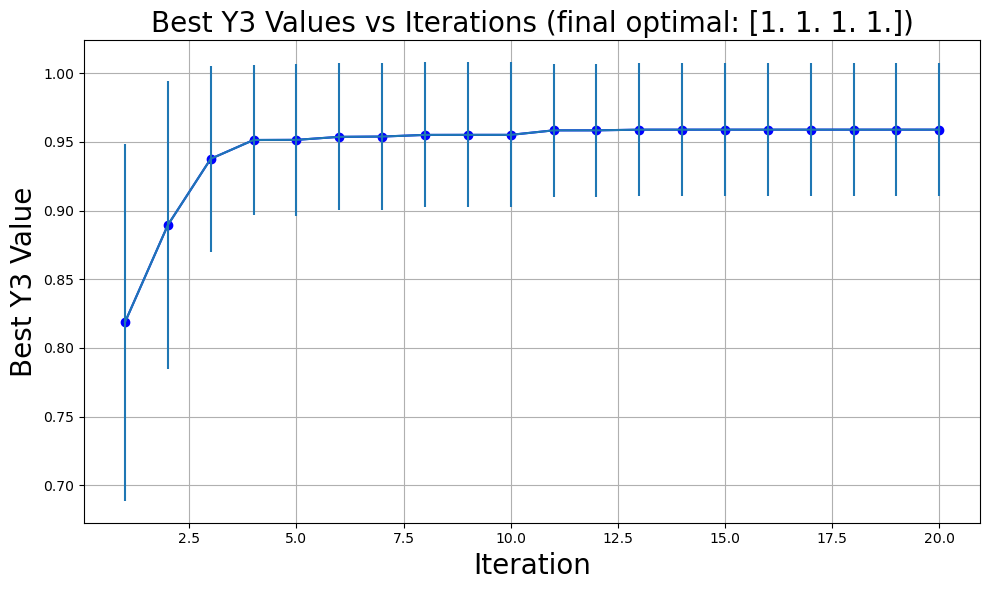

In [27]:
def plot_gp_mean(model, bounds, resolution=100):
    x1 = torch.linspace(bounds[0, 0], bounds[1, 0], resolution, dtype=dtype, device=device)
    x2 = torch.linspace(bounds[0, 1], bounds[1, 1], resolution, dtype=dtype, device=device)
    X1, X2 = torch.meshgrid(x1, x2)
    grid = torch.stack([X1.flatten(), X2.flatten()], -1)
    with torch.no_grad():
        mean = model.posterior(grid).mean.cpu().numpy().reshape(resolution, resolution)
    return X1.cpu().numpy(), X2.cpu().numpy(), mean

def update(frame):
    plt.clf()
    X1, X2, mean = plot_gp_mean(models[frame], bounds)
    cp = plt.contourf(X1, X2, mean, levels=50, cmap=cm.viridis)
    plt.colorbar(cp)
    plt.scatter(frames_x[frame][:, 0], frames_x[frame][:, 1], color="red")
    plt.title(f"Iteration {frame+1}")



# Plotting the best Y values vs iterations
plt.figure(figsize=(10, 6))
plt.plot(iterations, np.mean(supra_best,axis=0), marker='o', linestyle='-', color='b')
plt.errorbar(iterations, np.mean(supra_best,axis=0),yerr=np.std(supra_best,axis=0))
plt.title('Best Y3 Values vs Iterations (final optimal: [1. 1. 1. 1.])', fontsize = 20)
plt.xlabel('Iteration', fontsize = 20)
plt.ylabel('Best Y3 Value', fontsize = 20)
plt.grid(True)
plt.tight_layout()
plt.show()

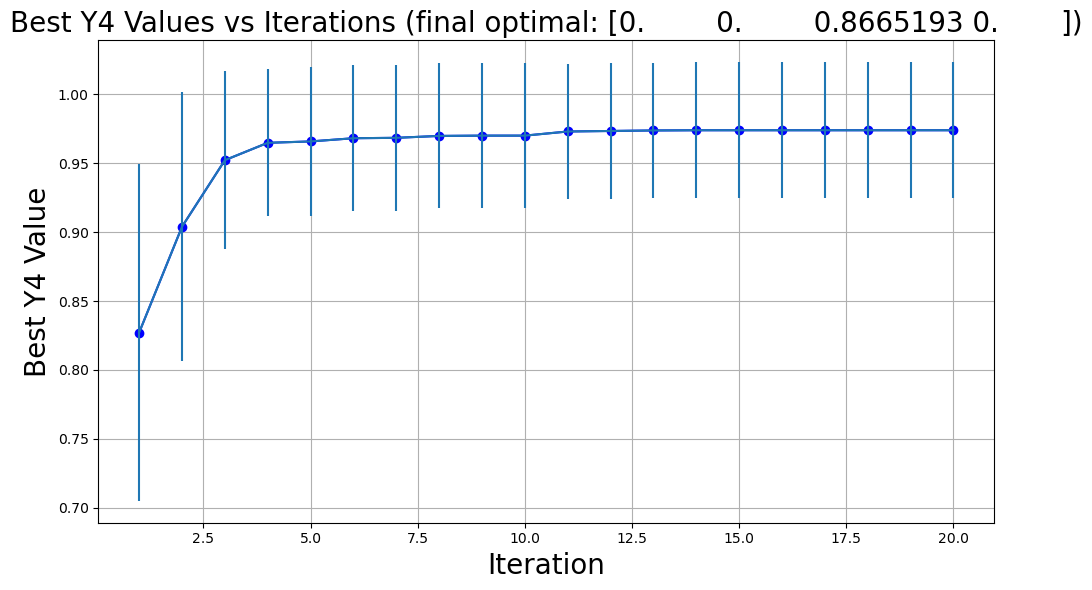

In [29]:
def plot_gp_mean(model, bounds, resolution=100):
    x1 = torch.linspace(bounds[0, 0], bounds[1, 0], resolution, dtype=dtype, device=device)
    x2 = torch.linspace(bounds[0, 1], bounds[1, 1], resolution, dtype=dtype, device=device)
    X1, X2 = torch.meshgrid(x1, x2)
    grid = torch.stack([X1.flatten(), X2.flatten()], -1)
    with torch.no_grad():
        mean = model.posterior(grid).mean.cpu().numpy().reshape(resolution, resolution)
    return X1.cpu().numpy(), X2.cpu().numpy(), mean

def update(frame):
    plt.clf()
    X1, X2, mean = plot_gp_mean(models[frame], bounds)
    cp = plt.contourf(X1, X2, mean, levels=50, cmap=cm.viridis)
    plt.colorbar(cp)
    plt.scatter(frames_x[frame][:, 0], frames_x[frame][:, 1], color="red")
    plt.title(f"Iteration {frame+1}")



# Plotting the best Y values vs iterations
plt.figure(figsize=(10, 6))
plt.plot(iterations, np.mean(supra_best,axis=0), marker='o', linestyle='-', color='b')
plt.errorbar(iterations, np.mean(supra_best,axis=0),yerr=np.std(supra_best,axis=0))
plt.title('Best Y4 Values vs Iterations (final optimal: [0.        0.        0.8665193 0.       ])', fontsize = 20)
plt.xlabel('Iteration', fontsize = 20)
plt.ylabel('Best Y4 Value', fontsize = 20)
plt.grid(True)
plt.tight_layout()
plt.show()